## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

## 1. Reading the data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re

from collections import Counter
%matplotlib inline

In [2]:
# Read files.
# The training data is indeed not encoded as UTF-8 so note the encoding parameter.
train = pd.read_csv('train.csv', encoding='cp1252')
test = pd.read_csv('test.csv')

latlons = pd.read_csv('latlons.csv')
address = pd.read_csv('addresses.csv')

print('training set:', train.shape,',', 'test set:', test.shape,',', 'latlons:',latlons.shape,',', 'address:',address.shape)

training set: (250306, 34) , test set: (61001, 27) , latlons: (121769, 3) , address: (311307, 2)


## 2. Data Cleaning

### 2.1 Data Leakage

We need to remove all data just prior to the event of interest, in our case, 'payment_amount','balance_due', 'payment_due', 'payment_status', etc. These columns will cause our model too optimistic, which leads to a overfitting problem since this kind of information will not be given with unseen data in practice. Also without knowing the result of the status of tickets will be paid on time, there is no way we can know them. 

In [3]:
# In order to avoid either data leakage or too many missing values, remove some columns does not exist 
# in test dataset except for the target variable 'compliance'.
elimi_col = [col for col in train.columns if(col not in test.columns)][:-1]
print(elimi_col)

train = train.drop(elimi_col, axis=1)

['payment_amount', 'balance_due', 'payment_date', 'payment_status', 'collection_status', 'compliance_detail']


In [4]:
address.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [5]:
latlons.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


By just looking at the first sight, it appears that we can merge address and latlons dataframes by the common column "address".

### 2.2 Merging

In [6]:
loca = address.merge(latlons, how = 'outer', left_on = 'address', right_on = 'address')
loca.head()

,ticket_id,address,lat,lon
0,22056,"2900 tyler, Detroit MI",42.390729,-83.124268
1,77242,"2900 tyler, Detroit MI",42.390729,-83.124268
2,77243,"2900 tyler, Detroit MI",42.390729,-83.124268
3,103945,"2900 tyler, Detroit MI",42.390729,-83.124268
4,138219,"2900 tyler, Detroit MI",42.390729,-83.124268


Note that a same property can have multiple ticket_id (tickets).

In [7]:
train = train.merge(loca, how = 'inner', left_on = 'ticket_id', right_on = 'ticket_id')
test = test.merge(loca, how = 'inner',left_on = 'ticket_id', right_on = 'ticket_id')
train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,10.0,25.0,0.0,0.0,305.0,NaN,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,10.0,75.0,0.0,0.0,855.0,NaN,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


In [8]:
print('training set:', train.shape)
print("test set:",test.shape)

training set: (250306, 31)
test set: (61001, 30)


## 3. Data Preprocessing & Missing Values

In [9]:
train.isnull().sum()[train.isnull().sum() >= 1]

violator_name                     34
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
state                             93
zip_code                           1
non_us_str_code               250303
hearing_date                   12491
fine_amount                        1
grafitti_status               250305
compliance                     90426
lat                                3
lon                                3
dtype: int64

In [10]:
test.isnull().sum()[train.isnull().sum() >= 1]

violator_name                    28
violation_zip_code            36977
mailing_address_str_number     1014
mailing_address_str_name          3
state                           331
zip_code                          3
non_us_str_code               61001
hearing_date                   2197
fine_amount                       0
grafitti_status               58780
lat                               5
lon                               5
dtype: int64

As you can see the above, three columns 'violation_zipcode','non_us_str_code','grafitti_status' have too many missing values. Therefore, remove these columns.

### 3.10 Violation Zip Code, Non Us Str Code, Grafitti status

In [11]:
train.drop(['violation_zip_code','non_us_str_code','grafitti_status'], axis=1, inplace=True)
test.drop(['violation_zip_code','non_us_str_code','grafitti_status'], axis=1, inplace=True)

### 3.11 Number of NaN

In [12]:
# For the convenience for counting the number of nulls in each row, create the new column 'num_null'
train['num_null'] = train.isnull().sum(axis=1)
test['num_null'] = test.isnull().sum(axis=1)

### 3.12 Lat/Lon

In [13]:
# Training set lat,lon:
# Since there are some missing values found in both training and test set, 
# we need to manually find the lat and lon coordinates from google map by searching the given addresses

# 20424 bramford, Detroit MI, (42.446558,-83.022996)
train.iloc[65578,-3] = 42.446558
train.iloc[65578,-2] = -83.022996

# Fail to find the lat and lon coordinates for the ticket_id 223598 and 280256 from google map 
# since the rest of two other places are showing too wide area (google map cannot pinpoint where it is).

# Test Set lat,lon:

# 20424 bramford, Detroit MI, (42.446558,-83.022996)
test.iloc[20459,-3] = 42.446558
test.iloc[20459,-2] = -83.022996

# 8325 joy rd, Detroit MI 48204, (42.359024, -83.150799)
test.iloc[28350,-3] = 42.359024 
test.iloc[28350,-2] = -83.150799

# 1201 elijah mccoy dr, Detroit MI 48208, (42.358760, -83.080382)
test.iloc[28416,-3] = 42.358760
test.iloc[28416,-2] = -83.080382

# 12038 prairie, Detroit MI 482O4, (42.376943, -83.143206)
test.iloc[31925,-3] = 42.376943
test.iloc[31925,-2] = -83.143206

# 6200 16th st, Detroit MI 48208 (42.360104, -83.095872)
test.iloc[55400,-3] = 42.360104
test.iloc[55400,-2] = -83.095872

# Check how many null values are in train and test
print('Missing values in training lat and lon:',len(train[train.lon.isnull()]), 'Missing values in test lat and lon:',len(test[test.lon.isnull()]))

# Check the table.
train[train.lon.isnull()]

Missing values in training lat and lon: 2 Missing values in test lat and lon: 0


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,...,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,address,lat,lon,num_null
191722,223598,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","HJADJANTONI, MICHAEL",445.0,FORDYCE,437.0,FOREST,DETROIT,MI,...,10.0,25.0,0.0,0.0,305.0,0.0,"445 fordyce, Detroit MI",NaN,NaN,2
245981,280256,Department of Public Works,"McCants, Angela","HOLDINGS LLC, FORDYCE",8300.0,FORDYCE,151.0,POTOMIC,ROCHESTER HILLS,MI,...,0.0,0.0,0.0,0.0,0.0,NaN,"8300 fordyce, Detroit MI",NaN,NaN,3


In [14]:
# As you can see, there are still two missing values which cannot be found in google map; therefore, needed to be filled with
# 0.0 lat and lon (or some distinguishable number from other lat, lon but I decided to choose 0.0). 
# Except for these two values, all the values do not have any problem so leave the rows instead of dropping the rows.
train.lat[train.lat.isnull()] = 0.0
train.lon[train.lon.isnull()] = 0.0

Since we converted most of violation addresses to lat and lon coordinate, 'violation_street_number','violation_street_name','address' variables are no longer needed.

### 3.13 Violation Street Number , Violation Street Name, Address

In [15]:
train.drop(['violation_street_number','violation_street_name','address'], axis = 1, inplace = True)
test.drop(['violation_street_number','violation_street_name','address'], axis = 1, inplace = True)

### 3.14 Country / State / City / New Country

In [16]:
# As you can see the country and city columns, there are some discrepancies between city and country. 
# ex) on ticket number 218570, city is Ontario, Canada but the country denotes USA.
train[train.state.isnull()].iloc[:,4:15].head()

,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition
183911,NaN,P. O. BOX 26334,MANAMA HAHRAIN,NaN,0,USA,2009-04-22 10:45:00,2009-05-28 10:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Default
186126,3212.0,MCCARRON CRES,"MISS, ONTARIO, CANADA",NaN,L5N 3H5,USA,2009-05-08 10:40:00,2009-06-18 13:30:00,22-2-88,"Failure of owner to keep property, its sidewal...",Responsible by Admission
188915,NaN,FOXWOOD CHALKY ROAD,STOCKBURG KENT,NaN,0,USA,2009-06-04 13:30:00,2009-10-29 10:30:00,9-1-104,Excessive weeds or plant growth one- or two-fa...,Responsible by Default
190375,1.0,PARTIGLIANO,LUCCA,NaN,55067,USA,2009-06-23 13:30:00,2009-08-05 13:30:00,9-1-105,Rodent harborage one-or two-family dwelling or...,Responsible by Admission
191245,29.0,CHERRY TREE CT,"CHARLESTON LONDON, ENGLAND",NaN,SE 770X,USA,2009-07-07 09:50:00,2009-08-18 13:30:00,9-1-104,Excessive weeds or plant growth one- or two-fa...,Responsible by Admission


In [17]:
# Let's check some info when state values are NaN
train[train.state.isnull()][['mailing_address_str_name','city','zip_code','country','state']]

,mailing_address_str_name,city,zip_code,country,state
183911,P. O. BOX 26334,MANAMA HAHRAIN,0,USA,NaN
186126,MCCARRON CRES,"MISS, ONTARIO, CANADA",L5N 3H5,USA,NaN
188915,FOXWOOD CHALKY ROAD,STOCKBURG KENT,0,USA,NaN
190375,PARTIGLIANO,LUCCA,55067,USA,NaN
191245,CHERRY TREE CT,"CHARLESTON LONDON, ENGLAND",SE 770X,USA,NaN
193547,THORN STREET,"Woodville, United Kingdom",Deli-7DN,USA,NaN
194701,TOOLEY,LONDON SE12ET,0,USA,NaN
203041,BRIARWOOD AVE,"TORONTO ONTARIO, CANADA",M9W6C9,USA,NaN
203042,BRIARWOOD AVE,"TORONTO ONTARIO, CANADA",M9W6C9,USA,NaN
203043,BRIARWOOD AVE,"TORONTO ONTARIO, CANADA",M9W6C9,USA,NaN


In order to correct the mismatches in cities and countries, search the name of the city from google map and correct the name of the country manually. As you probably notice, there are a lot of cities not only just mismatched but also erroneously spelled e.g) TOKO, OSKA, SUREY, VAN COUVER.

In [18]:
# Below is the list of misspelled and mismatched cities.
# While iterating over each raw, any of cities or countries in the list appears, 
# replace the erroneous labels on country column to correct labels. If there is nothing erroneous then label USA.
def nation_conv(element):
    
    singapore = 'WCEGA|PLAZA|PENISULA PLAZA|PENISULA AVE|PENINSULA|PENINSALA PLAZA|SINAGAPORE|SUNGAPORE|SINGA PORE|SINGAPO|SINGAPORE|WCEGA TOWER|BUKIT BATOK|SANDY PALM|BATOK'
    canada = 'SUN RIDGE|SURRY|RICHMOND, BC|RICHMOND|RICHMOND V7A4V3|VAN COUVER|EDMONTON|SUREY|YELLOWKNIFE|WINNIPEG MANTOBA|VANCOUVER|ALBERTA|CANADA|ONTARIO|TORONTO|RICHMOND BC|WINDSOR|CALGARY|ALDERGROVE'
    israel = 'RAMOT|ISRAEL|RAANANA|KIRYAT MOZKIN|RAMOT JERUSALEM|RAMONT JERUSALEM'
    uk = 'WARWICK|ROTHERHAM|PAIGNTON|ONCHAN ISLE OF MAN|NORTH PORTSMOUTH|TORTOLA|SHEFFIELD|SCARBOUROUGH|SCARBOROUGH|LANARKSHIRE|NEW CASTLE UPON TYM|MICKLEOVER|LANDONDERRY|DUNDALK|HERT FORDSHIRE|THORTON CLEVELEY\'S|SWINDON|STAFFORDSHIRE|SOUTHERNESS|SOUTH PORT|CHINNOR ORON|CHELTENHAM|CHATHAM|BURY|CANTERBURY|CARLUKE|CHARLTON|FARNBOROUGH HANTS|CHURCH TOWN|HATFIELD|MANCHESTER|ESSEX|LANCASHIRE|WARKFIELD BERKSHIRE|WARFIELD BERKSHIRE|TRURO|BROMLEY|BRIGHT|BRIGHTON|BICKERLEY RINGWOOD|BERKSHIRE|SALISBURY|CARLISLE CUMBRIAN|UNITED KINGDOM|LONDON|ENGLAND|CHESHIRE|KENT|NEWTONMORE|UNITED KINGDO|ECKINGTON, SHEFFIELD|WISHAW|LODON ,N2OJE,UK|OJE|SALISBURY,WILT,SP2, OQD,'
    egypt = 'NEW CIARO|EGYPT|ST FATIMA SQ HELIOP|CAIRO'
    france = 'PARIS|FRANCE|ALQUE MORTES|MATISSE CHAMPS SUR'
    thai = 'BANGKOK|THAILAND|BONGKOK'
    australia = 'QUEENSLAND|SMYLHES CREEK|NEDLAND|FASSI FERN |BELLS BROOK|BULLSBRPPK|BULLSHROOK|BUNDALL|ELLES GROVE|CROYDON|CROSSOVER|COLDSTREAM|BULLSBROOK|BRISBANE OLD|BLACK TOWN|BELROSE|BASSENDEAN|AVALON CITY|ROBINA|QUEANBEYAN|NSW|AUSTRALIA|ROBINA QLD|AUSTRALI|VICTORIA|QUENSLAND|BOX HILL NORTH VICT|MT. BARKER|NEW SOUTH WALES|ROSE BAY'
    bahrain = 'MANAMA'
    italy = 'DI QUATIRO CA|LUCCA|ALZATE'
    holland = 'VOORBURG|VEGHEL|NETHERLAND'
    zealand = 'AUCKLAND|New Zealand'
    japan = 'OSKA|KOMAE SHI|TOKYO|TOYKO|TOKO|JAPAN|CHIBA CITY'
    china = 'TAI O|QINGXIU|QING XIU|NEW PRAYN|SHANGHAI|HONG KONG|TAIPEI|KWON TONG|KWUN TONG'
    germany = 'WALDKRAIBURG|MUNICH|BERLIN'
    india = 'SONEPAT HARYANA|ISLAMABAD'
    arab = 'DUBAI'
    malay = 'SUBANG JAYA|SALANGOR'
    indonesia = 'SABANG JAYA'
    lebanon = 'LEBANON'
    nigiria = 'ALAUSA'
    norway = 'NORWAY'
    poland = 'POZNAN'
    etc = 'TADA CITY|BEULAH SOUTH'
    
    nations = [singapore,canada,israel,uk,egypt,france,thai,australia,bahrain,italy,holland,zealand,japan,china,germany,india,arab,malay,indonesia,lebanon,nigiria,norway,poland,etc]
    labels = ['SIN','CAN','ISR','UK','EGY','FRA','THI','AUS','BAH','ITA','HOL','NZL','JAP','CHN','GER','IND','ARA','MAL','IDN','LEB','NIG','NOR','POL','ETC']
    
    # If we create a dictionary, labeling would be so much easier.
    code = dict.fromkeys([])
    
    for nation, label in zip(nations,labels):
        code.update(dict.fromkeys(nation.split('|'), label))
    
    for nation in nations:
        found = list(map(lambda x: x.upper(),re.findall('\\b' + nation + '\\b', element, re.IGNORECASE)))
        if(len(found) > 0):
            return code[found[0]]
        continue
    
    return 'USA'


In [19]:
test[test['city'].isnull()]

,ticket_id,agency_name,inspector_name,violator_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,country,...,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon,num_null
12495,306086,Department of Public Works,"May, Tanya","CHASE HOME FINANCE LLC, .",8,BROOKSEDGE BLVD,NaN,OH,43081,USA,...,200.0,20.0,10.0,20.0,0.0,0.0,250.0,42.411773,-83.155902,1


As mentioned before, there are a lot of incorrect information on country column. Consequently, it is necessary to createa new column by applying the above function 'nation_conv' for describing violator's mailing country. 

In [20]:
# Apply the function.
train['new_country'] = train['city'].map(nation_conv)

# Based on google map, the name of the city in test dataset considered as a missing value is actually Westerville,
# which matches with the state and street name and zipcode.
test.city.fillna('NULL', inplace=True)
test.city.iloc[12495] = 'Westerville'

# Apply the function on test set. 
test['new_country'] = test['city'].map(nation_conv)

Some name of cities, for example WATERLOO, VICTORIA, are used widely in english-speaking countries. Therefore, in order to avoid misclassification, manually label those cities by using google map. In addition, as mentioned, there are some places that cannot be found in google map and label them as ETC.

In [21]:
# Training Set:
# city: WATERLOO, BELGIUM
train['new_country'].iloc[236844] = 'BEL'
train['new_country'].iloc[247422] = 'BEL'

# city: BEVAN WAY ABBOTSFORD B.C V256R3
train['new_country'].iloc[240635] = 'CAN'
train['new_country'].iloc[240806] = 'CAN'

# city: BELIZE CITY
train['new_country'].iloc[244547] = 'BLZ'

# Test Set:
#city: BELIZE CITY
test['new_country'].iloc[4328] = 'BLZ'

# UNITED KINGDOM
test['new_country'].iloc[20878] = 'UK'
test['new_country'].iloc[5647] = 'UK'
test['new_country'].iloc[5648] = 'UK'
test['new_country'].iloc[17870] = 'UK'
test['new_country'].iloc[17871] = 'UK'
test['new_country'].iloc[16513] = 'UK'
test['new_country'].iloc[21689] = 'UK'
test['new_country'].iloc[22436] = 'UK'
test['new_country'].iloc[22268] = 'UK'
test['new_country'].iloc[17911] = 'JAP'

# ETC list (failed to find the exact locations by google)
test['new_country'].iloc[14051] = 'ETC'
test['new_country'].iloc[14050] = 'ETC'
test['new_country'].iloc[22103] = 'ETC'
test['new_country'].iloc[14308] = 'ETC'
test['new_country'].iloc[2482] = 'ETC'
test['new_country'].iloc[18154] = 'ETC'
test['new_country'].iloc[10523] = 'ETC'
test['new_country'].iloc[568] = 'ETC'
test['new_country'].iloc[8580] = 'ETC'
test['new_country'].iloc[19819] = 'ETC'
test['new_country'].iloc[10857] = 'ETC'
test['new_country'].iloc[21689] = 'ETC'
test['new_country'].iloc[16413] = 'ETC'
test['new_country'].iloc[3087] = 'ETC'
test['new_country'].iloc[10656] = 'ETC'
test['new_country'].iloc[13203] = 'ETC'
test['new_country'].iloc[12860] = 'ETC'
test['new_country'].iloc[19478] = 'ETC'
test['new_country'].iloc[19479] = 'ETC'
test['new_country'].iloc[5656] = 'ETC'
test['new_country'].iloc[10776] = 'ETC'
test['new_country'].iloc[19061] = 'ETC'

# MAYNARD RD, WALTHAM : MA 
train.state.iloc[[245957,245958]] = 'MA'
test.state.iloc[20598] = 'DE'

In [22]:
# If mailing addresses are not domestic, change them to 'OOS' which stands for out of states.
train.state[train['new_country'] != 'USA'] = 'OOS'
test.state[test['new_country'] != 'USA'] = 'OOS'

In [23]:
# Let's see how many unique names in city column.
print('unique city names in training set:',len(set(train.city)))
print('unique city names in test set:',len(set(test.city)))

unique city names in training set: 5184
unique city names in test set: 3266


In [24]:
# It appears that some values are duplicated due to extra space or upper or lower case difference even though they are
# the same.
train.city = train.city.apply(lambda x: x.upper().strip())
test.city = test.city.apply(lambda x: x.upper().strip())

In [25]:
# As you can see the results, we could greatly reduce the number of duplications.
print('unique city names in training set:',len(set(train.city)))
print('unique city names in test set:',len(set(test.city)))

unique city names in training set: 4322
unique city names in test set: 2694


In [26]:
# Zip_code for non-us countries: 'OOS'
train.zip_code[train.new_country != 'USA'] = 'OOS'
test.zip_code[test.new_country != 'USA'] = 'OOS'

The rows whose state column value is NaN should be converted to string type since machine learning algorithms cannot take in None type as input. Especially in this case, we cannot not even infer any of city, state and zip_code by the given information (e.g mailing_address_str_name) label them 'NULL'. 

In [27]:
null_city_index = train[train.state.isnull()].index
train['city'].iloc[null_city_index] = 'NULL'
train['zip_code'].iloc[null_city_index] = 'NULL'
train['state'].iloc[null_city_index] = 'NULL'

In [28]:
# Check if there is any states other than us states in state columns.
us_state = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

not_us_state = []
all_state = set(train.state)|set(test.state)

for a in all_state:
    if(a not in us_state):
        not_us_state.append(a)

        
print(not_us_state)

# Make sure that exclude 'OOS' and 'NULL'
not_us_state.remove('OOS')
not_us_state.remove('NULL')

not_us_state

['PR', 'BC', 'ON', 'UK', 'QC', 'BL', 'VI', 'QL', 'NB', 'NULL', 'OOS']


['PR', 'BC', 'ON', 'UK', 'QC', 'BL', 'VI', 'QL', 'NB']

In [29]:
# Below rows are wrong abbreviation for the state.

# According to google map, the state of this row supposed to be Virgina VA not VI.
# Since the rest of VI represents Virgin Island in US so remove VI from not_us_state list
train.state.iloc[15713] = 'VA'
not_us_state.remove('VI')

# According to google map, the state of this row supposed to be Nevada NV not NB.
train.state.iloc[181834] = 'NV'
train.state.iloc[181835] = 'NV'

# Most of states denoted as 'NB' supposed to be 'NE'; therefore, from the not_us_state list, we need to remove it 
# to avoid an error when we create the dictionary later on. NB also stands for New Brunswick which is the province in 
# Canada but decide not to manually alter since the number of rows actually New Brunswick is negligible.

train.state[train.state == 'NB'] = 'NE'
test.state[test.state == 'NB'] = 'NE'

not_us_state.remove('NB')

# Many rows are wrongly classified as USA. 
train.state.iloc[248498] = 'OOS'
train.new_country.iloc[248498] = 'SIN'
train.state.iloc[241977] = 'OOS'
train.new_country.iloc[241977] = 'SIN'

train.state.iloc[107274] = 'OOS'
train.new_country.iloc[107274] = 'CAN'
train.state.iloc[107275] = 'OOS'
train.new_country.iloc[107275] = 'CAN'

train.state.iloc[20801] = 'OOS'
train.new_country.iloc[20801] = 'CHN'
train.state.iloc[20802] = 'OOS'
train.new_country.iloc[20802] = 'CHN'

#test.state.iloc[338993] = 'OOS'
#test.new_country.iloc[338993] = 'JAP'
#test.state.iloc[338995] = 'OOS'
#test.new_country.iloc[338995] = 'JAP'

test.state.iloc[6550] = 'OOS'
test.new_country.iloc[6550] = 'JAP'

test.state.iloc[6551] = 'OOS'
test.new_country.iloc[6551] = 'JAP'

test.state.iloc[9266] = 'OOS'
test.new_country.iloc[9266] = 'JAP'

#test.state.iloc[357567] = 'OOS'
#test.new_country.iloc[357567] = 'SIN'

test.state.iloc[33881] = 'OOS'
test.new_country.iloc[33881] = 'SIN'
test.state.iloc[2736] = 'OOS'
test.new_country.iloc[2736] = 'SIN'
test.state.iloc[3570] = 'OOS'
test.new_country.iloc[3570] = 'ETC'
test.state.iloc[5427] = 'OOS'
test.new_country.iloc[5427] = 'ETC'
test.state.iloc[11289] = 'OOS'
test.new_country.iloc[11289] = 'ETC'
test.state.iloc[20175] = 'OOS'
test.new_country.iloc[20175] = 'ETC'
test.state.iloc[20176] = 'OOS'
test.new_country.iloc[20176] = 'ETC'
test.state.iloc[20234] = 'OOS'
test.new_country.iloc[20234] = 'ETC'

test.state.iloc[34188] = 'OOS'
test.new_country.iloc[34188] = 'CAN'
test.state.iloc[34189] = 'OOS'
test.new_country.iloc[34189] = 'CAN'

test.state.iloc[48595] = 'OOS'
test.new_country.iloc[48595] = 'AUS'
test.state.iloc[48596] = 'OOS'
test.new_country.iloc[48596] = 'AUS'

# The country denoted as USA but has non-us states in state column should be converted to the proper labels.
nation_map = dict.fromkeys(['BC','ON','QC'],'CAN')
nation_map['BL'] = 'GER'
nation_map['UK'] = 'UK'
nation_map['QL'] = 'AUS'
nation_map['PR'] = 'ETC'

for st in set(not_us_state):
    train.new_country[train.state == st] = nation_map[st]
    test.new_country[test.state == st] = nation_map[st]
    
    train.state[train.state == st] = 'OOS'
    test.state[test.state == st] = 'OOS'



In [30]:
# Including NULL and OOS ('Out of States'), there should be 54 states in training set and 53 states in test set (no NULL value).
print('# of states in training set:',len(set(train.state)))
print('# of states in test set:',len(set(test.state)))

# of states in training set: 54
# of states in test set: 53


In [31]:
# Some rows whose city column has ST THOMAS are classified as VA which supposed to be VI (Virgin Irland)
va_island = train[train.state == 'VA'].city.str.extractall(r'(.* THOMAS)').index.levels[0]
train.state.iloc[va_island] = 'VI'

va_island_test = test[test.state == 'VA'].city.str.extractall(r'(.* THOMAS)').index.levels[0]
test.state.iloc[va_island_test] = 'VI'

### 3.15 Zip Code

Zipcode column comprises string and integer; therefore, first thing to do is to convert all the zipcode to string. Also, simplify the international zipcodes as OOS 'Out Of States'. If there is invalid place cannot be found even in google map, then label them as 'NULL'. In addition, we could find many invalid zipcode which consist of three digits or less. These should be also converted to 'NULL'. Lastly, remove hyphen sign which connects main zipcode (usually 5 digits) between detail zipcodes for unity.

In [32]:
# Need to standardized the zip_code type. (Some of them are string and some of them are integer)
train.zip_code = train.zip_code.apply(lambda x: str(x))
test.zip_code = test.zip_code.apply(lambda x: str(x))

In [33]:
# Zipcode for Out of states is OOS
train.zip_code[train.state == 'OOS'] = 'OOS'
test.zip_code[test.state == 'OOS'] = 'OOS'

# US zipcode whose default value is 0 changes to NULL
train.zip_code[((train.zip_code == '0') | (train.zip_code == 0)) & (train.new_country == 'USA')] = 'NULL'
test.zip_code[((test.zip_code == '0') | (test.zip_code == 0)) & (test.new_country == 'USA')] = 'NULL'

In [34]:
# Find wrong format zipcode which consists from 0 to 3 digits. We can safely assume that upto 3 digits zipcode
# are wrong type format; even though 4 digits can be problematic as well, the case starts with 0 postal code can be
# 5 digits only if the type is string. ex) 04513. 
train.zip_code[train.zip_code.str.match(r'^([0-9]{0,3})?$')] = 'NULL'
test.zip_code[test.zip_code.str.match(r'^([0-9]{0,3})?$')] = 'NULL'

In [35]:
# Unify the format of 9 digits or 8 digits postal code as non-hyphen(or non-special characters) postal code. 
# ex) 12345-6789 => 123456789
train.zip_code = train.zip_code.apply(lambda x: re.sub('[^A-Za-z0-9]','',x))
test.zip_code = test.zip_code.apply(lambda x: re.sub('[^A-Za-z0-9]','',x))

### 3.16 Hearing Date

The reason why I chose to treate the hearing date column as nominal rather than interval is that hearing time has only 6 unique values which can be easier to classify.

In [36]:
# Fill missing values with xxxx-xx-xx xx:xx:xx.
train.hearing_date.fillna('xxxx-xx-xx xx:xx:xx', inplace=True)
test.hearing_date.fillna('xxxx-xx-xx xx:xx:xx', inplace=True)

In [37]:
# Split hearing dates by four: YR, MM, DD, time
train['HR_YR'] = train.hearing_date.apply(lambda x:x.split()[0].split('-')[0])
train['HR_MO'] = train.hearing_date.apply(lambda x:x.split()[0].split('-')[1])
train['HR_DD'] = train.hearing_date.apply(lambda x:x.split()[0].split('-')[2])

train['HR_time'] = train.hearing_date.apply(lambda x:x.split( )[1])

test['HR_YR'] = test.hearing_date.apply(lambda x:x.split()[0].split('-')[0])
test['HR_MO'] = test.hearing_date.apply(lambda x:x.split()[0].split('-')[1])
test['HR_DD'] = test.hearing_date.apply(lambda x:x.split()[0].split('-')[2])

test['HR_time'] = test.hearing_date.apply(lambda x:x.split( )[1])

### 3.17 Ticket Issued Date

Year, month, and day of the ticket issued date are treated as hearing date column except for the time part. Unlike the hearing time, it should be converted to minute basis to treat as interval type since it increases every 5 minutes, which can be too many if we create binary columns by pd.get_dummies.

In [38]:
# Split ticket issued date by four: YR, MM, DD, time
train['TI_YR'] = train.ticket_issued_date.apply(lambda x:x.split()[0].split('-')[0])
train['TI_MO'] = train.ticket_issued_date.apply(lambda x:x.split()[0].split('-')[1])
train['TI_DD'] = train.ticket_issued_date.apply(lambda x:x.split()[0].split('-')[2])

train['TI_MI'] = train.ticket_issued_date.apply(lambda x:int(x.split()[1].split(':')[0])*60 + int(x.split()[1].split(':')[1]))

test['TI_YR'] = test.ticket_issued_date.apply(lambda x:x.split()[0].split('-')[0])
test['TI_MO'] = test.ticket_issued_date.apply(lambda x:x.split()[0].split('-')[1])
test['TI_DD'] = test.ticket_issued_date.apply(lambda x:x.split()[0].split('-')[2])

test['TI_MI'] = test.ticket_issued_date.apply(lambda x:int(x.split()[1].split(':')[0])*60 + int(x.split()[1].split(':')[1]))

### 3.18 Violation Code / Violation Description

In [39]:
train[['violation_code','violation_description']].head()

,violation_code,violation_description
0,9-1-36(a),Failure of owner to obtain certificate of comp...
1,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...
2,9-1-36(a),Failure of owner to obtain certificate of comp...
3,9-1-36(a),Failure of owner to obtain certificate of comp...
4,9-1-36(a),Failure of owner to obtain certificate of comp...


As we can see some duplicated values, violation codes and descriptions are corresponding each other, which means we can eliminate violation_description column at the end of the preprocessing. (e.g 9-1-36(a) -> Failure of owner to obtain certificate of comp...)

In [40]:
# Even though we drop violation_description column, for the later purpose, let's appropriate the two columns.
code_description = train[['violation_code','violation_description']].drop_duplicates()

### 3.19 Fine Amount

In [41]:
# As you can see below, there is one missing value in training fine amount column (no missing value in test set).
train[train.fine_amount.isnull()].iloc[:,12:]

,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,...,num_null,new_country,HR_YR,HR_MO,HR_DD,HR_time,TI_YR,TI_MO,TI_DD,TI_MI
81440,22-2-88,"Failure of owner to keep property, its sidewal...",Not responsible by Dismissal,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2,USA,2007,01,29,13:30:00,2007,01,03,795


In [42]:
# Although I searched rows of the fine amount that shares the same violation code and disposition 
# in order to fill the missing value with reasonable amount, there is no common value. 
print(Counter(train[(train.violation_code == '22-2-88') & (train.disposition == 'Not responsible by Dismissal')].iloc[:,15:].fine_amount))

# Therefore, decided to use the most frequent fine amount 200.0 to fill the missing value.
train.fine_amount.fillna(200.0, inplace=True)

Counter({200.0: 1729, 3500.0: 1100, 1000.0: 875, 500.0: 722, 2500.0: 503, 10000.0: 59, 5000.0: 30, 345.0: 2, nan: 1})


### 3.20 Redundant Columns


In [43]:
# Take a look at what columns are left.
list(train.columns)

['ticket_id',
 'agency_name',
 'inspector_name',
 'violator_name',
 'mailing_address_str_number',
 'mailing_address_str_name',
 'city',
 'state',
 'zip_code',
 'country',
 'ticket_issued_date',
 'hearing_date',
 'violation_code',
 'violation_description',
 'disposition',
 'fine_amount',
 'admin_fee',
 'state_fee',
 'late_fee',
 'discount_amount',
 'clean_up_cost',
 'judgment_amount',
 'compliance',
 'lat',
 'lon',
 'num_null',
 'new_country',
 'HR_YR',
 'HR_MO',
 'HR_DD',
 'HR_time',
 'TI_YR',
 'TI_MO',
 'TI_DD',
 'TI_MI']

In [44]:
redundant = ['violator_name','mailing_address_str_number','mailing_address_str_name','city','country','violation_description','num_null','hearing_date','ticket_issued_date']
train.drop(redundant, inplace = True, axis = 1)
test.drop(redundant, inplace = True, axis = 1)

__hearing_date, ticket_issued_date__: Since we already split the time of these two columns in detail so they are not needed.<br>
__num_null__: As mentioned, this column is created for the convenience to check how many missing values in each row for preprocessing. For the later process, it is not needed.<br>
__mailing_address_str_name, mailing_address_str_number, violator_name, city__: There are too many unique values and too many typos to use them as machine learning algorithms' input.<br>
__country__: Many values are wronly classified, for example, the label supposed to be USA but Canada or vice versa.<br>
__violation_description__: It is tanamount to violation_code, just violation_description is described as english and violation_code is encoded; however, violation_code is much easier to display so decided to remove 'violation_description' column.

### 3.21 Compliance

For this assignment, our task is to predict whether a given blight ticket will be paid on time. Therefore, all we want to know is to 'will be paid on time' or not. Label 1 if the ticket will be paid on time. Otherwise, label 0 (Fill missing values with 0).

In [45]:
train.compliance.fillna(0.0,inplace=True)

In [46]:
# Also for modeling purpose, split the column from training set.
y = train.compliance.astype(int)
train.drop('compliance',axis=1, inplace = True)

### 3.22 Ticket ID

Ticket ID for test is important for the final result. It will be used for index of our final prediction.

In [47]:
test_id = test.ticket_id
test.drop('ticket_id',axis=1, inplace=True)

train_id = train.ticket_id
train.drop('ticket_id', axis=1, inplace=True)

### 3.23 Encoding

#### 3.231 Nominal Variable

In [48]:
train.head()

,agency_name,inspector_name,state,zip_code,violation_code,disposition,fine_amount,admin_fee,state_fee,late_fee,...,lon,new_country,HR_YR,HR_MO,HR_DD,HR_time,TI_YR,TI_MO,TI_DD,TI_MI
0,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",IL,60606,9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,...,-83.124268,USA,2005,03,21,10:30:00,2004,03,16,700
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin",MI,48208,61-63.0600,Responsible by Determination,750.0,20.0,10.0,75.0,...,-83.135118,USA,2005,05,06,13:30:00,2004,04,23,750
2,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",MI,48223,9-1-36(a),Not responsible by Dismissal,250.0,0.0,0.0,0.0,...,-83.096069,USA,2005,03,29,10:30:00,2004,04,26,820
3,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",MI,48214,9-1-36(a),Not responsible by City Dismissal,250.0,0.0,0.0,0.0,...,-83.095919,USA,xxxx,xx,xx,xx:xx:xx,2004,04,26,810
4,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",MI,48206,9-1-36(a),Not responsible by Dismissal,250.0,0.0,0.0,0.0,...,-83.208233,USA,2005,03,29,10:30:00,2004,04,26,780


In [49]:
ordinal_list = list(train.dtypes[train.dtypes=='object'].index)

In [50]:
print(ordinal_list)
list(map(lambda x: len(set(train[x])),ordinal_list))

['agency_name', 'inspector_name', 'state', 'zip_code', 'violation_code', 'disposition', 'new_country', 'HR_YR', 'HR_MO', 'HR_DD', 'HR_time', 'TI_YR', 'TI_MO', 'TI_DD']


[5, 173, 54, 4111, 235, 9, 18, 13, 13, 32, 6, 11, 12, 31]

#### 3.232 Number of Features

The list above is the length of each ordinal variable's unique value. Among many numbers, 4112 is noteceable which comes from 'zip_code' column. In order to work ordinal variables in machine learning algorithms, they must be binarized; however, in the process of binarization, the number of columns increases as the number of unique values in the original column, which can cause increasing variance of the model. This leads to overfitting.<br>
As a rule of thumb for a number of features, if we assume that variables are theoretically (perfectly) not correlated each other, N (number of samples) - 1 is allowable. If variables are perfectly correlated, N^(1/2) is the desirable number of features. If we follow this logic, as mentioned, zipcode can be potential threat to overfitting. Besides, 'zip_code' is not the only variable to represent geographical information but 'state' column (mailing_state) can represent where the violator's mailing address is. Therefore, I decide to remove 'zip_code' column. 

In [51]:
train.drop('zip_code',axis=1, inplace=True)
test.drop('zip_code',axis=1, inplace=True)

In [52]:
ordinal_list.remove('zip_code')
sum(list(map(lambda x: len(set(train[x])), ordinal_list)))

612

Before we binarize the nominal variables, check the types of each columns.

In [53]:
train.dtypes

agency_name         object
inspector_name      object
state               object
violation_code      object
disposition         object
fine_amount        float64
admin_fee          float64
state_fee          float64
late_fee           float64
discount_amount    float64
clean_up_cost      float64
judgment_amount    float64
lat                float64
lon                float64
new_country         object
HR_YR               object
HR_MO               object
HR_DD               object
HR_time             object
TI_YR               object
TI_MO               object
TI_DD               object
TI_MI                int64
dtype: object

In [54]:
# Check if two datasets have same columns.
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [55]:
# Check types as well.
test.dtypes == train.dtypes

agency_name        True
inspector_name     True
state              True
violation_code     True
disposition        True
fine_amount        True
admin_fee          True
state_fee          True
late_fee           True
discount_amount    True
clean_up_cost      True
judgment_amount    True
lat                True
lon                True
new_country        True
HR_YR              True
HR_MO              True
HR_DD              True
HR_time            True
TI_YR              True
TI_MO              True
TI_DD              True
TI_MI              True
dtype: bool

#### 3.233 Dummies

__ Make sure that features are represented in the same way in the training and test set before we apply machine learning algorithms__; if training and test sets have different numbers of features (or even if the numbers are the same, they must be equal columns) and we can't apply the model we learned on the training set to the test set anymore. Therefore, we need to concatnenate before using get_dummies.

In [56]:
border = len(train)
comb = pd.concat([train,test])

In [57]:
# Convert object type columns to dummies.
df_dummy = pd.get_dummies(comb)

In [58]:
# Double check if there is any missing values.
df_dummy.isnull().sum().sum()

0

In [59]:
# For modeling, split train and test as before.
X_train = df_dummy.iloc[:border,:]
X_test = df_dummy.iloc[border:,:]

In [60]:
print('Training set dim:',X_train.shape, ',', 'Test set dim:', X_test.shape)

Training set dim: (250306, 717) , Test set dim: (61001, 717)


## 4. Feature Selection

In [61]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [62]:
select = SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=1), threshold='median')
select.fit(X_train,y)
X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)

In [63]:
print('Training set dim:',X_train_sel.shape, ',', 'Test set dim:', X_test_sel.shape)

Training set dim: (250306, 359) , Test set dim: (61001, 359)


In [64]:
# By the function get_support(), we can actually see which features are chosen.
# We can use the variable mask later.
mask = select.get_support()
print('total features:',len(mask))
print('selected features\' index:\n',np.where(mask == True)[0])

total features: 717
selected features' index:
 [  0   1   2   3   4   6   7   8   9  10  11  12  13  15  16  23  25  26
  28  29  32  33  36  38  39  40  42  43  50  51  59  60  61  62  64  66
  67  71  73  76  79  80  83  84  85  87  88  89  90  93  94  98  99 103
 104 105 107 110 111 114 117 120 121 123 125 126 128 130 131 134 135 137
 139 141 143 144 145 146 147 148 154 155 157 158 159 160 161 162 164 165
 172 173 176 180 181 182 184 185 186 188 189 191 192 194 195 196 197 198
 200 201 207 208 209 210 212 213 217 219 220 221 225 226 230 231 234 235
 236 242 243 245 246 247 248 249 250 251 253 254 255 256 258 259 260 261
 262 263 264 265 266 267 268 271 273 274 275 278 279 280 281 282 283 284
 285 286 288 289 290 291 294 295 297 299 300 302 305 307 309 310 315 316
 317 318 321 325 326 327 334 336 337 338 339 340 343 357 358 359 402 408
 409 411 412 414 415 416 420 441 444 445 446 448 451 453 459 460 461 464
 465 468 475 486 490 499 500 501 508 509 510 543 548 553 554 555 556 558
 561

In [65]:
X_train_sel

array([[  250.,    20.,    10., ...,     0.,     0.,     0.],
       [  750.,    20.,    10., ...,     0.,     0.,     0.],
       [  250.,     0.,     0., ...,     0.,     0.,     0.],
       ..., 
       [ 1000.,     0.,     0., ...,     0.,     0.,     0.],
       [ 1000.,     0.,     0., ...,     0.,     0.,     0.],
       [ 1000.,     0.,     0., ...,     0.,     0.,     0.]])

## 5. Visualization

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

### 5.1 Target Variable

In [67]:
cc = Counter(y)
print('training set %:',cc[0]/len(train)*100, 'test set %:',cc[1]/len(train)*100)

training set %: 95.36687094995725 test set %: 4.633129050042747


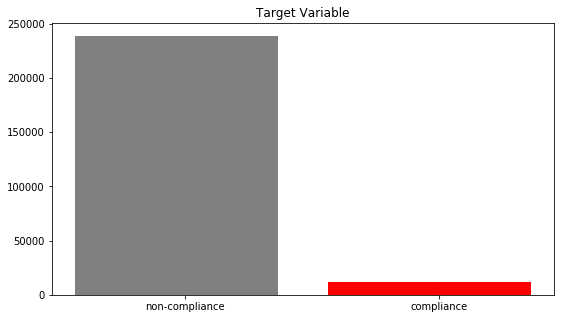

In [68]:
plt.figure(figsize=(9,5))
labels, values = zip(*Counter(y).items())
indexes = np.arange(len(labels))
width = 0.8
plt.bar(indexes, values,width,color=['grey','r'])
plt.xticks(indexes + width*.045,['non-compliance','compliance'])
plt.title('Target Variable')
plt.show()


The graph and the Counter function are showing that the data is highly imbalanced. Most of data is 0, which means as a measure of accuracy, auc_roc method is more encouraged to use.

### 5.2 Correlation

In statistics, the correlation coefficient measures the strength and direction of a linear relationship between two variables. The value is always between -1 and +1. Correlation implies how two variables (X and y) are correlated but not the causation. Pandas Correlation function only displays the data whose type is non-object so the dimensionality of the correlation table will be 11 X 11.

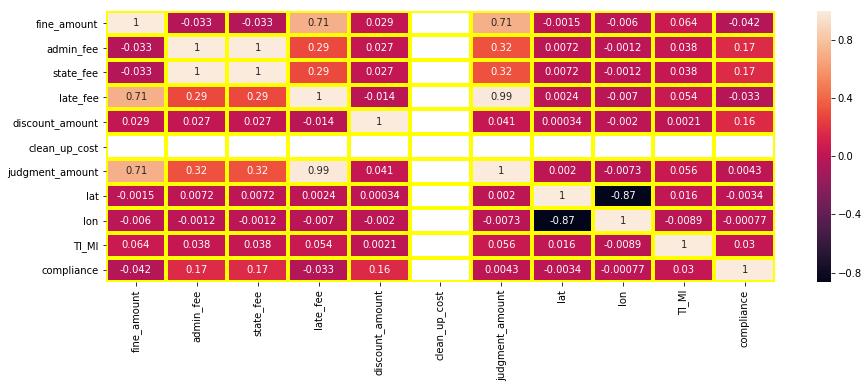

In [69]:
plt.figure(figsize=(15,5))
temp = pd.concat([comb.iloc[:border,:],y],axis=1)
sns.heatmap(temp.corr(), annot = True, linewidth=3, linecolor='yellow');

Among many features, admin_fee and state_fee are noticeable; therefore we will be looking at these two more in depth later.

### 5.3 PairPlot

For plotting, object type features should be excluded from the dataframe.

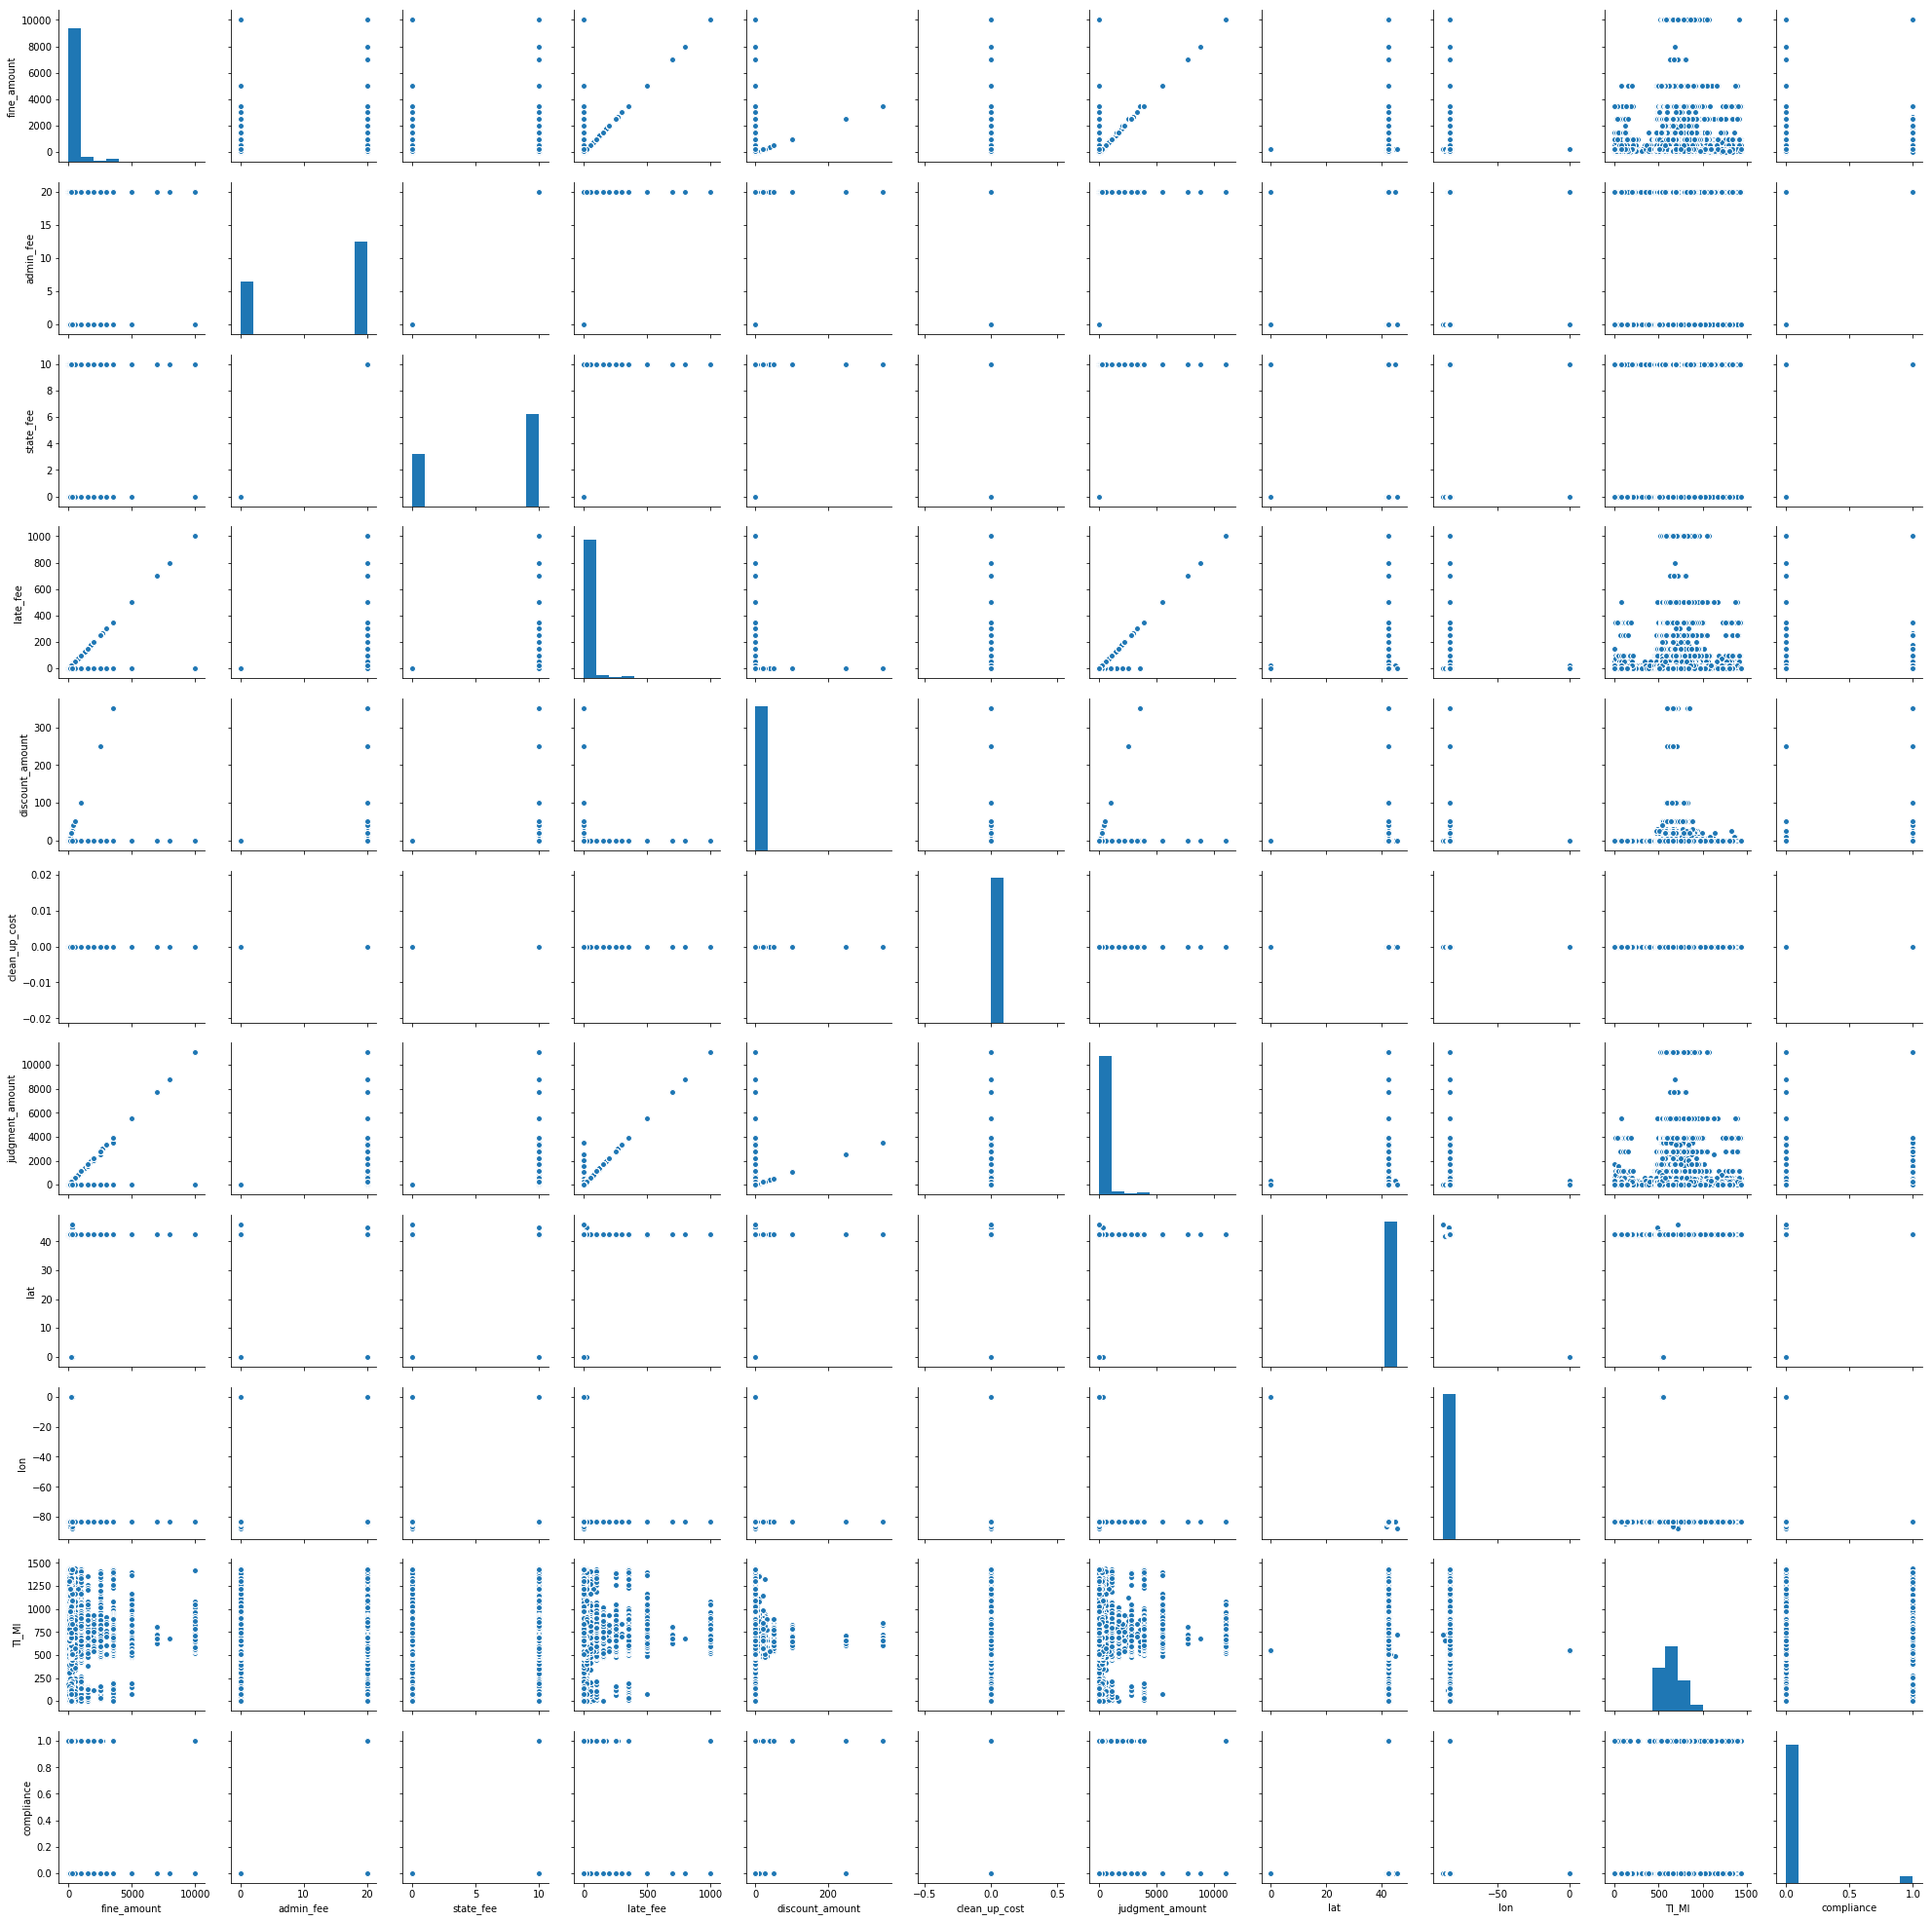

In [70]:
sns.pairplot(temp[temp.dtypes[temp.dtypes != 'object'].index]);

At first sight, the plots capture linearly separable patterns instead of completely non-linear random. Most of pairplots are either vertical line or horizontal line ,which represents the fact that the data is highly imbalanced or concentrated around specific area. Especially, the relationship between independent variables and dependent variables is the first thing to look closely. All of the graphs are showing two vertical lines (or even a dot) located at the end and start of x-axis.

### 5.4 State (mailing address state)

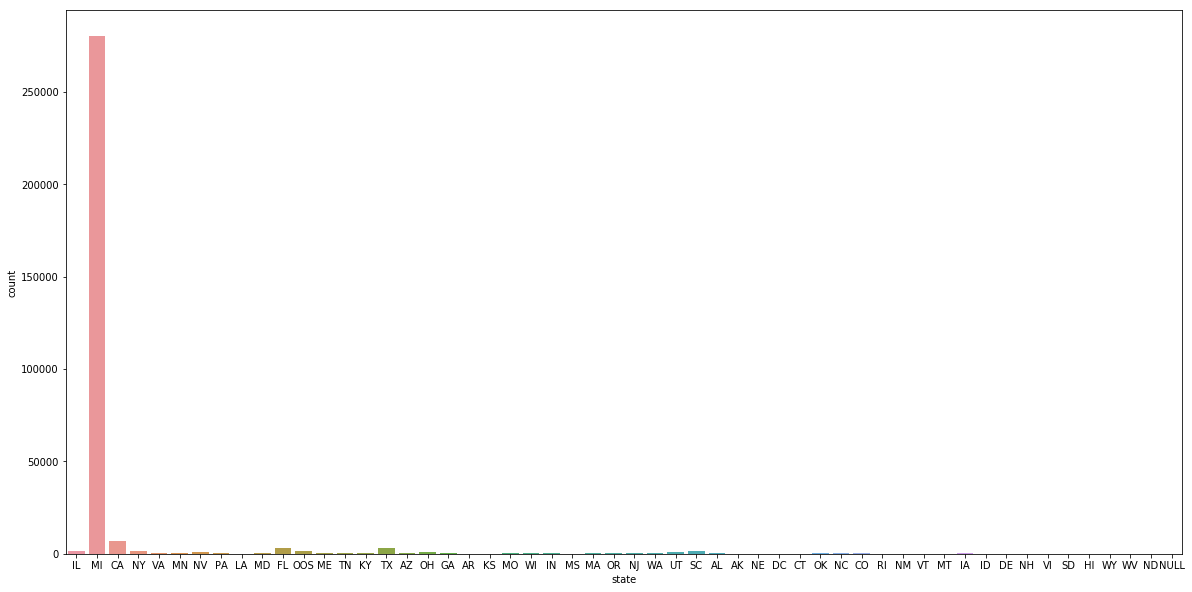

In [71]:
plt.figure(figsize=(20,10))
sns.countplot('state',data=comb)

As you can see, Michigan outnumbers other states, which is obvious since the project is about the city of Detroit. Therefore, I decide to visualize without Michigan.

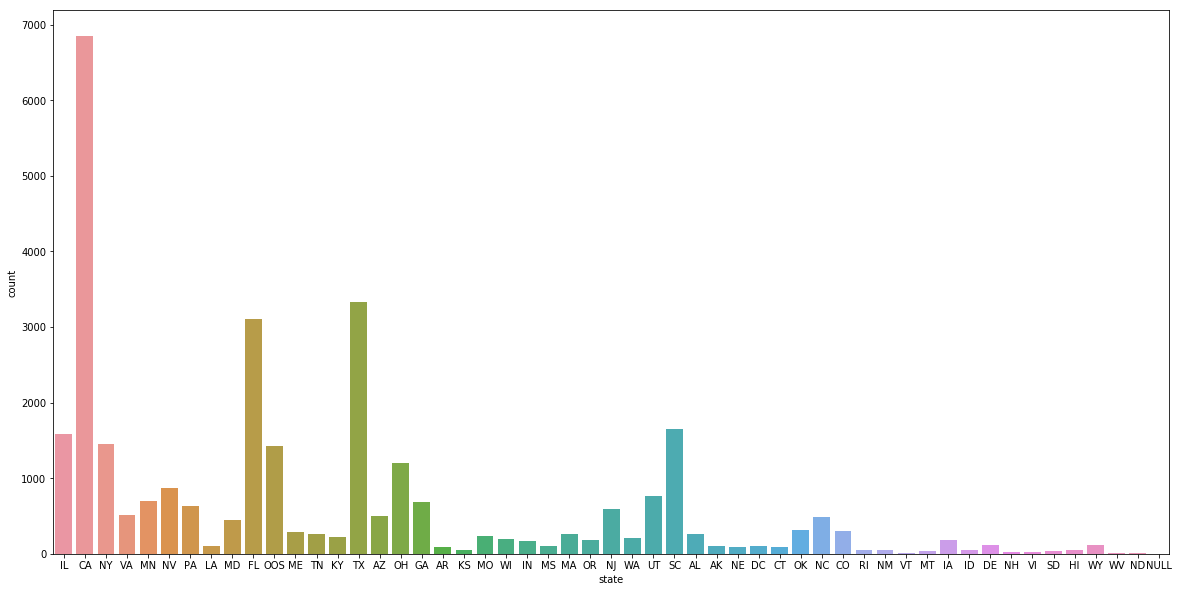

In [72]:
temp_MI = comb[comb.state != 'MI']
plt.figure(figsize=(20,10))
sns.countplot('state',data = temp_MI);

Except Michigan, the top three states are California, Texas, and Florida which exactly matches with the most populous U.S states data from United States Census. Instead of interpreting the result that people from these top states are likely to commit the blight, we can roughly analyze that the population size of the states plays important role.

### 5.5 Violation Code

For visualization purpose, violation code is converted to numbers by using LabelEncoder to avoid ticks overlapped each other on the graph, which is hard to see.

In [73]:
le = LabelEncoder().fit(train.violation_code)
vc = pd.Series(le.transform(train.violation_code))
df_vc = pd.concat([vc,y], axis=1)
df_vc.columns = ['code','compliance']
df_vc.head(8)

,code,compliance
0,182,0
1,102,1
2,182,0
3,182,0
4,182,0
5,182,0
6,101,0
7,100,0


In [74]:
# Count how many tickets were complied on time.
df_code = df_vc.groupby('code').agg('sum')

# Add a new column how many time codes occurred.
df_code['count'] = df_vc.groupby('code').count()

# Create a new column by dividing count column and compliance, which is the compliance rate.
df_code['rate'] = df_code['compliance']/df_code['count']

# Sort the dataframe by 'count' column.
df_code = df_code.sort_values('count',ascending=False)

# Remove the case violation code occurred less than one hundred times.
df_code = df_code[df_code['count'] > 100]

# Select only top 20 count values.
df_code = df_code.iloc[:20,:]

# Create the column for actual violation code.
df_code['actual'] = list(le.inverse_transform(df_code.index))

# Create the column for violation code description.
code_description.index = code_description.violation_code
code_description.drop('violation_code',inplace=True)
df_code['code'] = df_code.index
df_code = df_code.merge(code_description, left_on = 'actual',right_on='violation_code',how='inner')
df_code.index = df_code['code']
df_code.drop(['actual','code'],inplace=True,axis=1)
df_code.drop_duplicates('violation_code',inplace=True)

In [75]:
df_code

,compliance,count,rate,violation_code,violation_description
code,,,,,
182,4767,99091,0.048107,9-1-36(a),Failure of owner to obtain certificate of comp...
225,742,43471,0.017069,9-1-81(a),Failure to obtain certificate of registration ...
53,1352,28720,0.047075,22-2-88,"Failure of owner to keep property, its sidewal..."
131,1392,22536,0.061768,9-1-104,Excessive weeds or plant growth one- or two-fa...
55,308,7238,0.042553,22-2-88(b),Allowing bulk solid waste to lie or accumulate...
28,554,5394,0.102707,22-2-45,Violation of time limit for approved container...
190,58,5332,0.010878,9-1-43(a) - (Dwellin,Failure of owner of one- or two-family dwellin...
132,321,5072,0.063289,9-1-105,Rodent harborage one-or two-family dwelling or...
137,387,4814,0.080391,9-1-110(a),Inoperable motor vehicle(s) one- or two-family...


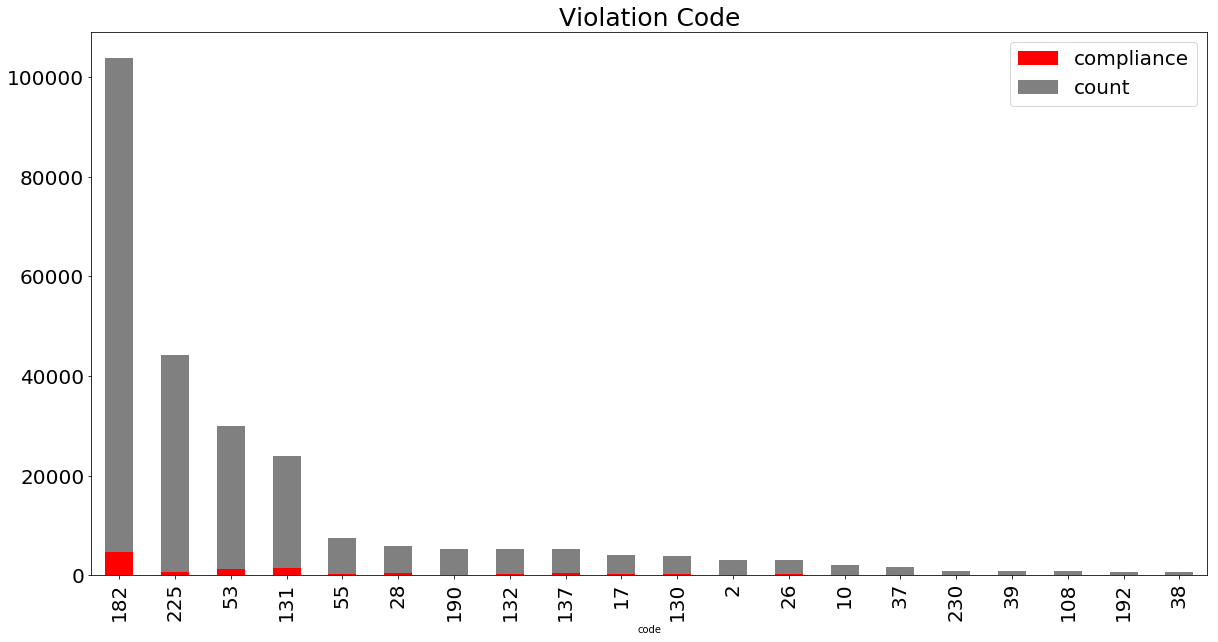

In [76]:
df_code[['compliance','count']].plot(kind='bar',stacked=True,colors=['red','grey'],figsize=(20,10));
ax = plt.gca();
ax.tick_params(axis='both', labelsize=20);
plt.legend(prop={'size':20});
plt.title('Violation Code', fontsize=25);

The code '9-1-43(a) - (Dwelling)' ('Failure of owner to obtain certificate of compliance') has the worst compliance rate 0.010878 and the code 22-2-61 ('Failing to secure City or Private solid waste collection containers and services') has the best compliance rate 0.120192. The best one's rate is approximately eleven times bigger than the worst one.

### 5.6 Administrative Fee & State Fee

Administrative Fee and State Fee are the most highly correlated non-object variables with target variable 0.17 respectively. Besides, we can assume that the fees how much violators have to pay may play an important role in prediction. Consequently it is worth analyzing the relationship between these variables and target variables.

In [77]:
Counter(train.admin_fee)

Counter({0.0: 90426, 20.0: 159880})

In [78]:
Counter(train.state_fee)

Counter({0.0: 90426, 10.0: 159880})

There are only two cases on each variable: \$0 or \$20 for administrative fee or \$0 or \$10 for state fee. Maybe it is better to extract the columns from training set and combine them as separate dataframe. Also, in order to see if there is any interaction among these columns, create a new column by adding admin_fee and state_fee.

In [79]:
fee = pd.concat([train[['admin_fee','state_fee']],y],axis=1)
fee['summ'] = fee.admin_fee + fee.state_fee

In [80]:
print(Counter(fee.compliance))
print('Not Paid on time:',list(Counter(fee.compliance).values())[0]/len(fee))
print('Paid on time:',list(Counter(fee.compliance).values())[1]/len(fee))

Counter({0: 238709, 1: 11597})
Not Paid on time: 0.9536687094995725
Paid on time: 0.046331290500427474


Let's check if there is any pattern when the violator paid on time.

In [81]:
fee[fee['compliance']==1].summ.head(10)

1     30.0
18    30.0
19    30.0
37    30.0
41    30.0
44    30.0
59    30.0
60    30.0
61    30.0
77    30.0
Name: summ, dtype: float64

In [82]:
set(fee[fee['compliance']==1].summ)

{30.0}

The pattern found is that all violators who paid on time were charged for both administrative and state fee. Now let's take a look at the other case: the violators who did not pay on time.

In [83]:
print(Counter(fee[fee['compliance'] == 0].summ))
print('Not paid on time & Charged:',list(Counter(fee[fee['compliance'] == 0].summ).values())[0]/len(fee[fee['compliance'] == 0]))
print('Not paid on time & No Charged at all:',list(Counter(fee[fee['compliance'] == 0].summ).values())[1]/len(fee[fee['compliance'] == 0]))

Counter({30.0: 148283, 0.0: 90426})
Not paid on time & Charged: 0.6211873033693744
Not paid on time & No Charged at all: 0.37881269663062556


Without visualization, the relationship between the violators who paid on time and fees were evident. Therefore, it is worth focusing on violators not paid on time.

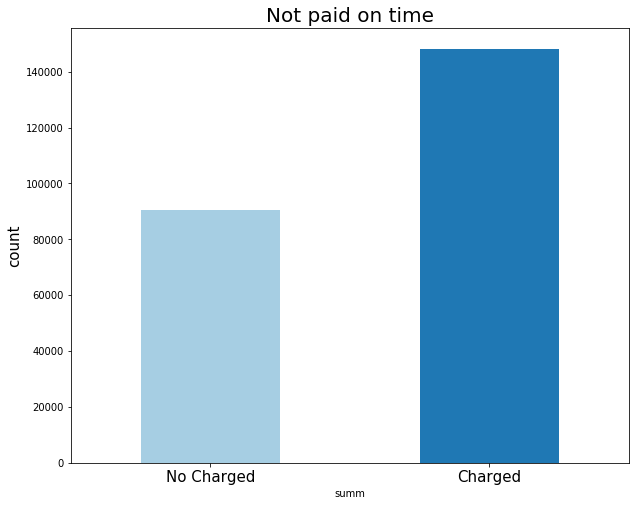

In [84]:
fee[fee['compliance']==0].groupby('summ').agg('count')['compliance'].plot(kind='bar',color=[plt.cm.Paired(np.arange(len([0,30])))],figsize=(10,8));
ax = plt.gca();
plt.title('Not paid on time',fontsize=20);
plt.xticks(np.arange(2),['No Charged','Charged'],rotation=0,fontsize=15);
plt.ylabel('count',fontsize=15);

From this analysis, there are some important takeaways. First as mentioned, all the violators who paid on time had been charged both administrative and state fees \$30. The violators who did not pay on time consist of two groups: Not charged any of these fees or fully charged as the groups paid on time. However, the charged group is approximately twice bigger than the group with no charge. We may be able to gain a better insight by considering other variables which engender the ratio difference. ex. maybe the violation code or explanation code can help explaining such a difference between the group with charge and no charge in the violators who did not pay on time.

## 6. Modeling

In [85]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB

Since the dataset is highly imbalanced, it is important to keep the ratio of two classes in each cross validation split. Among many cross-validation methodologies, StratifiedKFold is the first thing we need to consider.

In [86]:
kfold = StratifiedKFold(10, random_state = 1)

In [87]:
X_train_sel

array([[  250.,    20.,    10., ...,     0.,     0.,     0.],
       [  750.,    20.,    10., ...,     0.,     0.,     0.],
       [  250.,     0.,     0., ...,     0.,     0.,     0.],
       ..., 
       [ 1000.,     0.,     0., ...,     0.,     0.,     0.],
       [ 1000.,     0.,     0., ...,     0.,     0.,     0.],
       [ 1000.,     0.,     0., ...,     0.,     0.,     0.]])

### 6.1 Logistic Regression

250,000 samples are definitely not small sized dataset and due to the limit of my laptop's CPU and memory, I decide to use Logistic Regression. Logistic Regression is a simple well-behaved, as the problem is linearly separable. Also it is pretty robust to noise with proper regularization (L1/L2). 

In [88]:
lr = LogisticRegression(random_state=1)

param = {
            'C': [0.001],
            'penalty':['l1'],
            'class_weight':[{1:2}]
        }

lrCV = GridSearchCV(lr, param_grid=param, cv=kfold, verbose=True, n_jobs=-1, scoring='roc_auc')
lrCV.fit(X_train_sel,y)
lrCV_best = lrCV.best_estimator_
print(lrCV.best_params_)

# CV = 10 (ORIGINAL WITHOUT INSPECTOR NAME) - preserved in original file.
# * {'C': 0.001, 'class_weight': {1: 2}, 'penalty': 'l1'} - 0.8642844

# CV = 10 (SELECTFROMMODEL)
# * {'C': 0.001, 'class_weight': {1: 2}, 'penalty': 'l1'} - 0.86427307750706317


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.8min finished


{'C': 0.001, 'class_weight': {1: 2}, 'penalty': 'l1'}


In [89]:
lrCV.best_score_

0.86427307750706317

In [90]:
result_log = pd.DataFrame(lrCV.predict(X_test_sel), index = test_id)
result_log

,0
ticket_id,
284932,0
285362,0
285361,0
285338,0
285346,0
285345,0
285347,0
285342,0
285530,0


In [91]:
# To check, we can count how many 0 and how many 1 are predicted
result_summary = result_log.apply(pd.value_counts)
result_summary['%'] = result_summary.apply(lambda x:x/np.sum(result_summary[0])*100)
result_summary.columns = ['count','%']

In [92]:
result_summary

,count,%
0,58490,95.883674
1,2511,4.116326


This 0 and 1 ratio might be promising and optimistic signal since the ratio and that of original dataset are very alike.

### 6.2 Support Vector Machine

In [93]:
sv = LinearSVC(random_state=2018)

param_grid = {
    'loss':['squared_hinge'],
    'class_weight':[{1:1}],
    'C': [0.001],
    'penalty':['l1'],
    'dual':[False]
}

gs_sv = GridSearchCV(sv, param_grid = param_grid, verbose = 1, cv = kfold, n_jobs = 1, scoring = "roc_auc")
gs_sv.fit(X_train_sel,y)
gs_sv_best = gs_sv.best_estimator_
print(gs_sv.best_params_)

# L2 + Squared Hinge (default) + dual True
# {'C': 0.03, 'class_weight': {1: 1}, 'penalty': 'l2'} - 0.8221119743329911

# L2 + Hinge + dual True
# {'C': 0.001, 'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l2'} - 0.83519746888834068 (15%)

# L1 + Squared Hinge + dual False - 0.8585770577014018 (1.17%)
# {'C': 0.001, 'class_weight': {1: 1}, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}

# L2 + Squared Hinge + dual False - 0.82509376943573753
# {'C': 0.001, 'class_weight': {1: 2}, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}



Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.0min finished


{'C': 0.001, 'class_weight': {1: 1}, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}


In [94]:
gs_sv.best_score_

0.8585770577014018

In [95]:
result_svm = pd.DataFrame(gs_sv.predict(X_test_sel), index = test_id)
result_svm

,0
ticket_id,
284932,0
285362,0
285361,0
285338,0
285346,0
285345,0
285347,0
285342,0
285530,0


In [96]:
# To check, we can count how many 0 and how many 1 are predicted
result_summary = result_svm.apply(pd.value_counts)
result_summary['%'] = result_summary.apply(lambda x:x/np.sum(result_summary[0])*100)
result_summary.columns = ['count','%']

In [97]:
result_summary

,count,%
0,60287,98.829527
1,714,1.170473


### 6.3 Bernoulli Naive Bayes Classifier

In [98]:
bnb = BernoulliNB()
gs_bnb = GridSearchCV(bnb, param_grid = {'alpha': [0.001],
                                         'binarize': [1]}, verbose = 1, cv = kfold, n_jobs = 1, scoring = "roc_auc")
gs_bnb.fit(X_train_sel,y)
gs_bnb_best = gs_bnb.best_estimator_
print(gs_bnb.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


{'alpha': 0.001, 'binarize': 1}


In [99]:
gs_bnb.best_score_

0.82114125745285671

In [100]:
result = pd.DataFrame(gs_bnb.predict(X_test_sel), index = test_id)
result

,0
ticket_id,
284932,0
285362,0
285361,0
285338,0
285346,0
285345,0
285347,0
285342,0
285530,0


In [101]:
# To check, we can count how many 0 and how many 1 are predicted
result_summary = result.apply(pd.value_counts)
result_summary['%'] = result_summary.apply(lambda x:x/np.sum(result_summary[0])*100)
result_summary.columns = ['count','%']

In [102]:
result_summary

,count,%
0,59457,97.468894
1,1544,2.531106


## 7. Feature Importance



### 7.1 Logistic Regression

Although we have already done measuring the feature importance by Random Forest at the feature selection stage, this time we can try it with fully tuned Logistic Regression.

In [103]:
coef_lr = lrCV.best_estimator_.coef_
print('Dimension of coefficient:',coef_lr.shape)
coef_lr

Dimension of coefficient: (1, 359)


array([[ -8.07938694e-03,   2.28022185e-01,   0.00000000e+00,
         -3.73267562e-02,   1.82472406e-01,   9.66280198e-03,
          0.00000000e+00,   7.11778681e-02,   5.56692567e-04,
         -9.87527917e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

Due to L1 regularization (Lasso), many coefficient estimates shrink to 0 since the absolute values of that least squares coefficient is less than lambda/2. This fact works as a main advantage for feature selection. There are less features for analysts to concern and significantly become easier to analyze as well.

In [104]:
# Check the number of columns.
sel_col = X_train.loc[:,mask].columns
print('Number of selected columns:', sel_col.shape)

Number of selected columns: (359,)


The mask variable comes from the feature selection part and this is from get_support function from feature selection. What it does is represent which features are chosen for feature selection as a form of binary(True or False) in an array. With the True and False list, we can extract the name of the features from X_train so that we can see which coefficients are corresponding to which features.

In [105]:
# Create a dataframe 
df_imp_lr = pd.DataFrame(np.reshape(coef_lr,-1),index=sel_col)
df_imp_lr.columns = ['importance']

# Create a new column for absolute values to sort elements efficiently.
df_imp_lr['abs'] = abs(df_imp_lr['importance'])

# Exclude 0 coefficients.
df_imp_lr = df_imp_lr[df_imp_lr['abs']>0]

# Sort
df_imp_lr.sort_values('abs',ascending=False)

,importance,abs
disposition_Responsible by Default,-1.385402,1.385402
disposition_Responsible by Determination,0.352136,0.352136
admin_fee,0.228022,0.228022
discount_amount,0.182472,0.182472
"agency_name_Buildings, Safety Engineering & Env Department",-0.098753,0.098753
lon,0.071178,0.071178
late_fee,-0.037327,0.037327
judgment_amount,0.009663,0.009663
fine_amount,-0.008079,0.008079
TI_MI,0.000557,0.000557


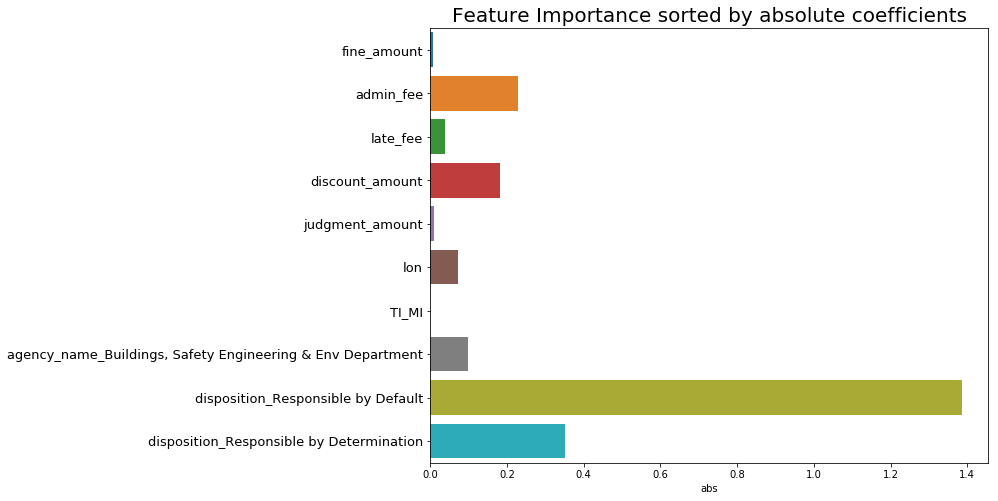

In [106]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_imp_lr['abs'], y=df_imp_lr.index);
plt.title('Feature Importance sorted by absolute coefficients', fontsize=20);
ax = plt.gca();
plt.yticks(fontsize=13);

### 7.2 Support Vector Machine

In [107]:
coef = gs_sv.best_estimator_.coef_
print('Dimension of coefficient:',coef.shape)
coef

Dimension of coefficient: (1, 359)


array([[ -2.56026797e-04,   1.76514946e-02,   5.09048207e-03,
         -5.58555395e-03,   5.42462200e-02,   6.12890364e-04,
         -1.21134543e-02,   5.98245485e-03,   4.11327180e-05,
         -2.84648148e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [108]:
# Check the number of columns.
sel_col = X_train.loc[:,mask].columns
print('Number of selected columns:', sel_col.shape)

Number of selected columns: (359,)


In [109]:
# Create a dataframe 
df_imp = pd.DataFrame(np.reshape(coef,-1),index=sel_col)
df_imp.columns = ['importance']

# Create a new column for absolute values to sort elements efficiently.
df_imp['abs'] = abs(df_imp['importance'])

# Exclude 0 coefficients.
df_imp = df_imp[df_imp['abs']>0]

# Sort
df_imp.sort_values('abs',ascending=False)

,importance,abs
disposition_Responsible by Default,-0.301250,0.301250
disposition_Responsible by Determination,0.154875,0.154875
discount_amount,0.054246,0.054246
HR_MO_12,-0.041825,0.041825
"agency_name_Buildings, Safety Engineering & Env Department",-0.028465,0.028465
admin_fee,0.017651,0.017651
lat,-0.012113,0.012113
lon,0.005982,0.005982
late_fee,-0.005586,0.005586
state_fee,0.005090,0.005090


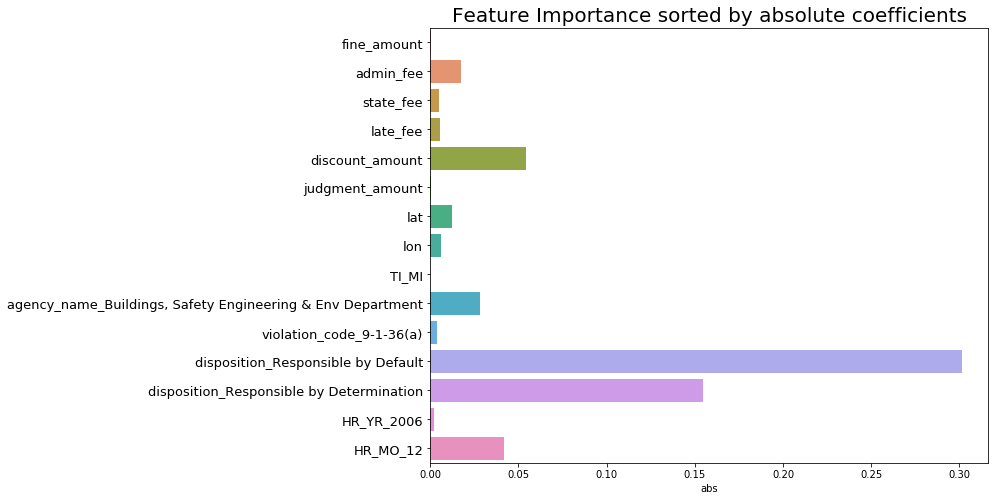

In [110]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_imp['abs'], y=df_imp.index);
plt.title('Feature Importance sorted by absolute coefficients', fontsize=20);
ax = plt.gca();
plt.yticks(fontsize=13);

An important thing to notice here is that the top five most important features selected by both models linearSVM and logistic regression are very similar. Especially, the top two "disposition_Responsible by Default" and "disposition_Responsible by Determination" are noticeably larger than any other features. By the fact that these two features are originally from "disposition (judgement and judgement type)", we can infer that among many factors, the decision made by Michigan (or Detroit city) court is very important whether the tickets will be paid on time or not. 

## 8 Learning Curve
Below is the criterion how well the models perform:<br>
- If two curves are close to each other and both of them have a low score. The model suffers from an under-fitting problem (High Bias)
- If training curve performs much better but validation curve has a lower score, then we can say the model suffers from an over-fitting problem (High Variance)

In [111]:
from sklearn.model_selection import learning_curve

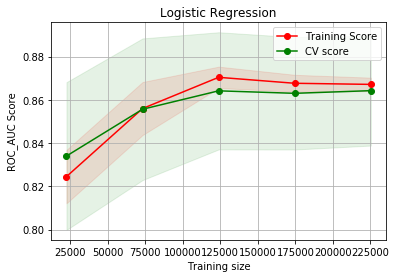

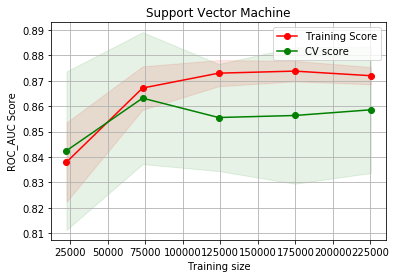

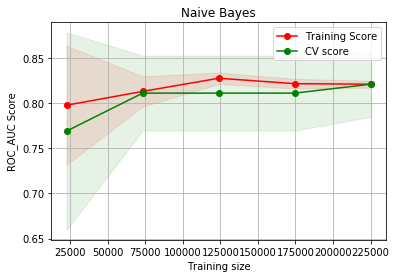

In [112]:
def lcplot(model,X,y,title,train_sizes=np.linspace(0.1,1.0,5)):
    
    train_sizes, train_scores, test_scores = learning_curve(model,X,y,cv=kfold,n_jobs=1,train_sizes=train_sizes,scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training size")
    plt.ylabel("ROC_AUC Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1, color='g')
    plt.plot(train_sizes,train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes,test_scores_mean, 'o-', color='g', label='CV score')
    plt.legend(loc='best')
    return plt

g = lcplot(lrCV.best_estimator_,X_train_sel,y,"Logistic Regression")
g = lcplot(gs_sv.best_estimator_,X_train_sel,y,"Support Vector Machine")
g = lcplot(gs_bnb.best_estimator_,X_train_sel,y,"Naive Bayes")


   Let's start with logistic regression learning curves. By the fact that the plot is showing the two curves are close to each other, we can say it is not clearly over-fitted model. Also, the validation score is not too low and at the same time the training score is not too high. As the sample size increases along x-axis, the initial segment of the validation curve is increasing as well; however, as the curve reaches the end, both curves are plateaued out. We can conclude that the model is neither over-fitted nor under-fitted. 
   For SVM learning curves, the gap between two curves indicates that the model suffers from variance (but not significantly high) and it would be improved by getting more samples (because the validation curve could converge toward the training curve if more training samples were added) or reducing more features. 
   On the other hand, Naive Bayes learning curves seem to suffer from bias, which means the model is under-fitted. As evidences, the score is not that high compared to other models and at the same time, the curves are roughly horizontal line (not increasing or decreasing). Unlike the SVM case, adding more data is very unlikely to help since the two curves have already converged. Perhaps we can fix the problem by adding more complexity by adding more features such as polynomial or any features representing interactions between features.

## 9. Conclusion

As instructed at the beginning, the source of the dataset is from Coursera. Therefore this project is originally designed for the students who register the course Applied Machine Learning in Python held by University of Michigan, Ann Arbor. I took this course and submitted my first copy about an year ago. I was able to score 79 percent (above 75 is the passing with full credit) of accuracy (roc_auc) in test data set.
This notebook is completely different than the notebook that I submitted an year ago and put definitely more effort to polish and used various approaches to achieve better performance.

By redoing this project, I could refresh my knowledge that I have not used for a long time and reinforce important machine learning concepts that I thought that I understood.

There are a few difficulties I encountered while I was working on the project. One of them was that I could not check my predictions directly with test dataset labels (y-test). 
As mentioned,  I took this course about an year ago so I cannot access to this course any more. Seemingly, Kaggle also provides the same dataset; however, the competition is open for only limited participants and blocked a submission. As a solution for this, I used a learning curve to check the validity of my models.  

The other difficulty that I can think of is there are a lot of typos and erroneous data in the dataset especially geographical information such as address, state, country etc. I had to do a lot of manual work with google map to correct these errors. Luckily a lot of typos are concentrated in international mailing address e.g. Tokyo is classified as city in US or Waterloo which is very popular city name in many western countries is considered as missing values on country column or the address even does not exist in google map, etc. Also the abbreviation for US states are erroneously denoted e.g Nebraska should be denoted as NE not NB. Virginia should be VA not VI which is Virgin Island. 

Lastly, due to the constraint of my laptop's memory and lack of CPU power, I only considered simple models such as Logistic Regression, Linear Support Vector Machine and Naive Bayes; however, if your system is sustanable enough to run more complex models including Random Forest or Boostings, I highly recommend using and combine them to improve the performance. For feature selection, feel free to try other methods, some of which are recursive feature engineering, univariate ANOVA, manuel selection (I could score slightly higher accuracy by dropping inspector_name column instead of feature selection by Random Forest; however, I decided to stick with feature selection method here.) or even PCA. 